# Neural Network for estimating policy trained using policy_gradient method
-------------------------------------------------------------------------------------------------------------------
This notebook solves the cart-pole task using a neural network and trained using the policy_gradient method

In [1]:
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
import time

/home/animesh/Programming/Envs/deep_learning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.set_random_seed(3)  # 3 is my lucky number :D :)
np.random.seed(3)  # for setting a seed to the numpy sample behaviour

define a function to play one episode of the cart-pole game and return the corresponding states and actions. Note that, for playing the game, we are using the neural network to take actions :). Yes! it's like inception. The neural network plays the game to get better at it.

#### Please don't mind the long function names :( I am sort of habitual to it ... 

In [3]:
get_environment = lambda: gym.make('CartPole-v0')  # create a lambda function for obtaining the environment

In [4]:
def play_one_cart_pole_episode(model, dis_gamma=0.9, render=False, ignore_done=False, max_steps=200):
    """
        play single episode of the cart-pole game in order to generate the learning data
        @args:
            model: neural network object used to predict the action
            dis_gamma: discount factor for calculating returns
        @returns:
            experience, episode_length => 
                (states, actions, returns): tuple of lists of state and return (**Not reward)
                length of the episode
    """
    # obtain the cart_pole environment
    env = get_environment()
    
    # reset environment to obtain the first set of observations
    obs = env.reset()
    
    # initialize the states and rewards lists
    states = [obs]
    actions = []
    rewards = []  # note that initial state has no reward corresponding to it
    
    # play the game untill it lasts
    done = False
    steps = 1
    while not done and steps <= max_steps:
        # render if value is true
        if render:
            env.render()
        
        action_probs = model.predict(obs)
        action = np.random.choice(range(len(action_probs)), p=action_probs)
        
        # take the action on the environment
        obs, reward, done, _ = env.step(action)
        
        # append the state and reward to appropriate lists
        states.append(obs)
        actions.append(action)
        rewards.append(reward)
        
        if ignore_done:
            done = False
        
        steps += 1

    # remove the last element from the states list since last state is not required for learning
    states.pop(-1)
    
    episode_length = sum(rewards)
    
    # -----------------------------------------------------------------
    # Tweak the reward function for faster learning
    # -----------------------------------------------------------------
    if episode_length < (max_steps - 1):
        rewards[-1] += -100
    # basically, if the cart falls in between episode, it gets a huge
    # negative reward
    # -----------------------------------------------------------------
    
    # now that we have the rewards, calculate the returns from them
    # Note that return for a state is the 
    # Expected value of rewards (here onwards) discounted by the discount factor \gamma
    # G(t) = r + (gamma * G(t + 1))
    
    # initialize the returns list **Note that the last state has a return of 0
    returns = [0]
    
    # calculate the returns in reverse order since it is efficient to do so
    for reward in reversed(rewards):
        returns.append(reward + (dis_gamma * returns[-1]))
    
    # remove the initial 0 return from the list
    returns.pop(0)
    
    # reverse the returns list
    returns = list(reversed(returns))
        
    # ensure the lengths of states, actions and returns are equal
    assert len(states) == len(actions) and len(actions) == len(returns), "Computation messed up"
    
    # don't forget to close the environment :D
    if render:
        time.sleep(1)
    env.close()
        
    # return the calculated lists
    return np.array(states), np.array(actions), np.array(returns), episode_length

Define the model class for the Neural Network computations

In [5]:
class Model:
    """
        Neural Network model for cart-Pole task
    """
    
    def __create_graph(self, eps=1e-12):
        """ 
            private helper to create tensorflow graph 
        """
        
        graph = tf.Graph()
        
        with graph.as_default():
            # define the input placeholders for training the model
            with tf.name_scope("Inputs"):
                x = tf.placeholder(tf.float32, shape=(None, self.ip_dim), name="input")
                y = tf.placeholder(tf.int32, shape=(None,), name="taken_action")
                g = tf.placeholder(tf.float32, shape=(None,), name="returns")
    
            # convert y into one_hot values
            with tf.name_scope("One_Hot_Encoder"):
                y_one_hot = tf.one_hot(y, depth=self.num_classes, name="one_hot")
    
            # define the neural computations pipeline
            x_ = x
            count = 1
            for width in self.hl_widths:
                x_ = tf.layers.dense(x_, width, activation=tf.nn.tanh, name="Dense_"+str(count))
                count += 1
                
            # add the last dense layer for prediction
            y_ = tf.layers.dense(x_, self.num_classes, use_bias=False, name="Dense_"+str(count))
            
            # define the predictions block
            with tf.name_scope("Predictions"):
                predictions = tf.nn.softmax(y_)
                
            # define the loss for the graph
            with tf.name_scope("Loss"):
                loss = -tf.reduce_sum((g * tf.log(tf.reduce_sum((predictions * y_one_hot), axis=-1) + eps)))
                
            # define the optimizer
            with tf.name_scope("Opimizer"):
                optimizer = tf.train.AdagradOptimizer(learning_rate=self.lr).minimize(loss)
                
            # define the init op
            with tf.name_scope("Errands"):
                init = tf.global_variables_initializer()
                
        # return the graph and important tensor handles
        return graph, x, y, g, predictions, loss, optimizer, init
                
    
    def __init__(self, input_dim, num_classes, depth=1, hl_widths=[64], lr=3e-3):
        """
            create a dense Neural Network model
            @args:
                input_dim: input dimensionality
                depth: number of hidden layers of the network. Note this 
                       doesn't include the last classification layer.
                hl_widths: list denoting the hidden layer widths of the network
                num_classes: final layer number of classes
                lr: learning rate 
        """
        
        # check if the depth and hl_widths are consistent
        assert depth == len(hl_widths), "hl_widths' length is not equal to depth"
        
        # attach the values to the object data
        self.ip_dim = input_dim
        self.depth = depth
        self.hl_widths = hl_widths
        self.num_classes = num_classes
        self.lr = lr
        
        # create the graph and obtain the handles to tensors
        self.graph, self.x, self.y, self.g, self.pred, self.loss, self.opt, self.init = self.__create_graph()
        
        # attach an interactive session to the model object
        self.sess = tf.Session(graph=self.graph)
        
        # initialize the graph with random values
        self.sess.run(self.init)
        
    
    def predict(self, inp_obs):
        """
            make a prediction based on the input observation
            @args:
                inp_obs: a single input observation
            @returns:
                pred: probability distribution over the possible actions
        """
        gra_in = np.expand_dims(inp_obs, axis=0)  # add the batch axis
        
        # use the session to make the prediction
        pred = np.squeeze(self.sess.run(self.pred, feed_dict={self.x: gra_in}))
        
        # return the calculated predictions
        return pred
        
    
    def fit(self, inp_obs, act_actions, returns, max_iter=300, convergence_thresh=1e-12, feed_back=True,
           feedback_factor=5):
        """
            fit the model on the givne data (input, action, return)
            @args:
                inp_obs: list of input observations
                act_actions: list of actions
                returns: list of obtained returns
        """
        # run the training until either convergence threshold is reached or max_iter are complete
        cnt = 1
        loss_delta = float('inf')
        prev_loss = 0
        while cnt <= max_iter and loss_delta > convergence_thresh:
            _, cur_loss = self.sess.run([self.opt, self.loss], feed_dict={
                                                                         self.x: inp_obs,
                                                                         self.y: act_actions,
                                                                         self.g: returns
                                                                     })
            if feed_back and cnt % (max_iter / feedback_factor) == 0:
                print("Current_step: ", cnt, "   Current_loss:", cur_loss)
            
            loss_delta = np.abs(cur_loss - prev_loss)
            prev_loss = cur_loss
            cnt += 1
            
        # print a message for training complete
        print("fit complete")
        return cur_loss

### Let's test the above defined abstractions. 

The model creates the neural network and has a very easy to use api => (fit and predict). Let's create a default model

In [6]:
model = Model(4, 2, depth=2, hl_widths=[32, 32])  # 4 = num_of_inputs, 2 = num_actions

Let's play an episode using this model (policy)

In [7]:
x, y, g, _ = play_one_cart_pole_episode(model)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Alright, now let's test if the fit function actually reduces the loss using the experience obtained from playing the first episode.

In [8]:
model.fit(x, y, g, max_iter=1000);

Current_step:  200    Current_loss: -4385.995
Current_step:  400    Current_loss: -5905.079
Current_step:  600    Current_loss: -6828.601
Current_step:  800    Current_loss: -7526.468
Current_step:  1000    Current_loss: -8106.0156
fit complete


Cool. This ensures that the abstractions created above work nicely. :) ... On to actually traing the model now.

### With the model and a function to play the episode, We will now perform the training

In [9]:
def train_network(policy_network, episodes_per_learn=10, epochs_per_learn=5000, no_of_epochs=10, feedback_chk=2):
    """
        improve the policy by playing episodes
        @args:
            policy_network: model of the policy
            episodes_per_learn: no_of_episodes to play for one training_session
            epochs_per_learn: iterations per training_session
    """
    print("Training start")
    print("-------------------------------------------------------------------------------------------")
    
    losses = []
    avg_episode_lengths = []
    
    for epoch in range(no_of_epochs):
        # generate data by playing episodes
        print("Epoch: ", epoch + 1)
        x, y, g, ep_lens = [], [], [], []
        for _ in range(episodes_per_learn):
            x_, y_, g_, ep_len = play_one_cart_pole_episode(policy_network)
            x.append(x_); y.append(y_); g.append(g_); ep_lens.append(ep_len)

        # concatenate all the data
        x = np.concatenate(x); y = np.concatenate(y); g = np.concatenate(g)

        # perform training on this data
        loss = policy_network.fit(x, y, g, max_iter=epochs_per_learn)
        
        if (epoch + 1) % feedback_chk == 0 or epoch == 0:
            # play an episode with render on
            play_one_cart_pole_episode(policy_network, render=True)
            
        losses.append(loss)
        avg_episode_lengths.append(np.mean(ep_lens))
            
        print("Average Episode Length: %d" %np.mean(ep_lens))
    print("-------------------------------------------------------------------------------------------")
    print("Training complete")
    
    return losses, avg_episode_lengths

train the network using the above defined function

In [10]:
losses, avg_episode_lengths = train_network(model, episodes_per_learn=10, no_of_epochs=20, feedback_chk=5)

Training start
-------------------------------------------------------------------------------------------
Epoch:  1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit

Current_step:  1000    Current_loss: -16288.296
Current_step:  2000    Current_loss: -17016.889
Current_step:  3000    Current_loss: -17470.879
Current_step:  4000    Current_loss: -17794.041
Current_step:  5000    Current_loss: -18044.785
fit complete
Average Episode Length: 190
Epoch:  7
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Current_step:  1000    Current_loss: 1750.646
fit complete
Average Episode Length: 200
Epoch:  14
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.s

fit complete
Average Episode Length: 200
Epoch:  20
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.

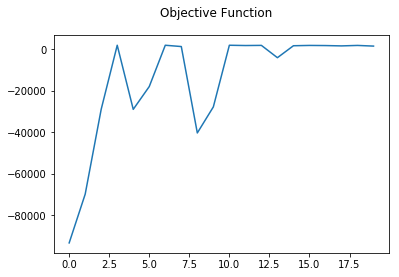

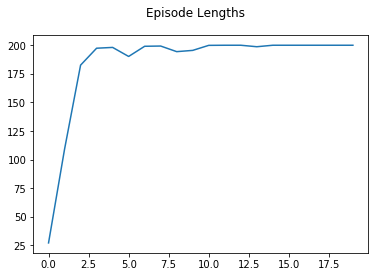

In [14]:
# plot the losses and the avg episode lengths
plt.figure().suptitle("Objective Function")
plt.plot(losses)

plt.figure().suptitle("Episode Lengths")
plt.plot(avg_episode_lengths)

run the following cell multiple times to see how the trained network performs

In [15]:
play_one_cart_pole_episode(model, render=True);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Check to see how long the cart can balance the pole. 
The following cell ignores the open-ai gym's time-step limit for 200 steps and overrides it to 400. Note that the override only works while testing the network and not while training it. Although the network was trained for 200 timesteps only, it can be seen that the network is able to balance more than that

Feel free to change the max_steps to even higher values

In [20]:
play_one_cart_pole_episode(model, render=True, ignore_done=True, max_steps=400);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


# I hope the notebook helped :) ...